In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})  
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 350)

# Import Data

In [2]:
#read the two files
card=pd.read_csv("./dataset/credit_card/cc_info.csv")

In [3]:
card.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [4]:
card.shape

(984, 5)

In [5]:
transaction=pd.read_csv("./dataset/credit_card/transactions.csv", parse_dates=['date'])

In [6]:
transaction.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [11]:
transaction.shape

(294588, 5)

data=pd.merge(transaction, card, how='left')

In [9]:
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294588 entries, 0 to 294587
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   credit_card                294588 non-null  int64         
 1   date                       294588 non-null  datetime64[ns]
 2   transaction_dollar_amount  294588 non-null  float64       
 3   Long                       294588 non-null  float64       
 4   Lat                        294588 non-null  float64       
 5   city                       294588 non-null  object        
 6   state                      294588 non-null  object        
 7   zipcode                    294588 non-null  int64         
 8   credit_card_limit          294588 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 22.5+ MB


Q: Identify users that never went above the monthly credit card limit

We will check how much each user has spent in total per calendar month and then compare to their monthly limit. This way we will identify users who went above the limit at least once. Finally we will pick all users not in this list.

In [13]:
#extract month from date
data['month']=data['date'].dt.month
  
#find total spent per month per user
users_above_limit = data.groupby(['credit_card', 'month']).apply(
                    lambda x: pd.Series({
                             # credit card limit
                            'credit_card_limit': x['credit_card_limit'].max(),
                             # total spent per month
                            'total_spent': x['transaction_dollar_amount'].sum()})
).reset_index()

In [14]:
users_above_limit.head()

,credit_card,month,credit_card_limit,total_spent
0,1003715054175576,7,20000.0,162.56
1,1003715054175576,8,20000.0,8441.51
2,1003715054175576,9,20000.0,11281.56
3,1003715054175576,10,20000.0,8954.21
4,1013870087888817,7,15000.0,281.43


In [19]:
users_above_limit.shape

(3797, 4)

In [17]:
test = data.groupby(['credit_card', 'month']).apply(
                    lambda x: pd.Series({
                             # credit card limit
                            'credit_card_limit': x['credit_card_limit'].min(),
                             # total spent per month
                            'total_spent': x['transaction_dollar_amount'].sum()})
).reset_index()

In [18]:
test.head()

,credit_card,month,credit_card_limit,total_spent
0,1003715054175576,7,20000.0,162.56
1,1003715054175576,8,20000.0,8441.51
2,1003715054175576,9,20000.0,11281.56
3,1003715054175576,10,20000.0,8954.21
4,1013870087888817,7,15000.0,281.43


In [20]:
users_above_limit = users_above_limit.query('total_spent>credit_card_limit')['credit_card'].unique()

In [21]:
print(len(users_above_limit))

122


In [22]:
users_no_limit = card['credit_card'][~card['credit_card'].isin(users_above_limit)]

In [23]:
print(len(users_no_limit), "users never went above the limit")

862 users never went above the limit


Q: Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day

We assume here that at the beginning of the new month, user total money spent gets reset to zero.

In [24]:
def alert_function (data_input, day_input, month_input, year_input):
      
   #extract day from timestamp
   data_input['date_truncated'] = data_input['date'].dt.date
   #add alert day to the dataset
   data_input['date_alerts'] = datetime.datetime(year_input, month_input, day_input)
      
   #subset dataset only keeping prior transactions in the same month
   tmp = data_input.query('date_truncated<=date_alerts.dt.date & month==date_alerts.dt.month').sort_values('date')
     
   #get cumsum of transaction amount by user
   tmp['total_spent'] = tmp.groupby('credit_card')['transaction_dollar_amount'].cumsum()
   #get previous day value of cumsum
   tmp['total_spent_previous_value'] = tmp.groupby('credit_card')['total_spent'].shift(1)
   #only keep rows when previous value was below the limit and current one is above
   tmp = tmp.query('total_spent>=credit_card_limit & total_spent_previous_value<credit_card_limit')
   #and date is the alert date
   tmp = tmp.query('date_truncated==date_alerts.dt.date') 
     
   return(tmp[['credit_card', 'total_spent', 'total_spent_previous_value', 'credit_card_limit', 'date_alerts']])     

In [25]:
print(alert_function(data, 16, 8, 2015))

             credit_card  total_spent  total_spent_previous_value  credit_card_limit date_alerts
230955  7850942767136368      4061.39                     3996.38               4000  2015-08-16
58222   2850146878241916      4005.39                     3988.08               4000  2015-08-16


Q: Build a model that returns all transactions that seem unusual and are worth investigating further

We will take the following approach:

Feature engineering. We will create the following new variables:

Geographical distance between transaction location and user home
Geographical distance between consecutive transactions
Time difference between consecutive transactions

Our model will use the variables above + transaction_amount. We will normalize all variables by user. That way we will identify anomalies based on a given user typical behaviour

We will cluster transactions, look into the cluster characteristics, and identify the “anomaly clusters”. All transactions falling into one of those clusters will be labeled as anomaly

In [27]:
import geocoder
import geopy.distance
#Feature Engineering
  
#1) To get distance from user home, we need to get lat/long of cities. We are using Bing API here, easier/faster to get an API key than google
#get unique queries for which we need lat/long
data['api_string'] = data['city'] + ',' + data['state'] + ',' + data['zipcode'].map(str)
string = data['api_string'].unique()
  
print("We will need to call the API", len(string), "times")
#dataset where we store the results
city_api = pd.DataFrame({'string': string,
                            'city_long' : np.nan,
                            'city_lat'  : np.nan})


Status code 401 from http://dev.virtualearth.net/REST/v1/Locations: ERROR - 401 Client Error: Unauthorized for url: http://dev.virtualearth.net/REST/v1/Locations?q=Houston%2CPA%2C15342&o=json&inclnb=1&key=MY_BING_API_KEY&maxResults=1


We will need to call the API 124 times


TypeError: 'NoneType' object is not subscriptable

In [36]:
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,...,credit_card_limit,month,date_truncated,date_alerts,api_string
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,...,20000,9,2015-09-11,2015-08-16,"Houston,PA,15342"
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,...,20000,10,2015-10-24,2015-08-16,"Houston,PA,15342"
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,...,20000,10,2015-10-26,2015-08-16,"Houston,PA,15342"
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,...,20000,10,2015-10-22,2015-08-16,"Houston,PA,15342"
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,...,20000,10,2015-10-26,2015-08-16,"Houston,PA,15342"


In [39]:
#pip install geopandas
#pip install geopy

In [45]:
import geopy

In [48]:
dir (geopy)

['AlgoliaPlaces',
 'ArcGIS',
 'AzureMaps',
 'BANFrance',
 'Baidu',
 'BaiduV3',
 'Bing',
 'DataBC',
 'GeoNames',
 'GeocodeEarth',
 'GeocodeFarm',
 'Geolake',
 'GoogleV3',
 'Here',
 'IGNFrance',
 'LiveAddress',
 'Location',
 'MapBox',
 'MapQuest',
 'MapTiler',
 'Nominatim',
 'OpenCage',
 'OpenMapQuest',
 'Pelias',
 'Photon',
 'PickPoint',
 'Point',
 'Timezone',
 'TomTom',
 'What3Words',
 'Yandex',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'compat',
 'distance',
 'exc',
 'extra',
 'format',
 'geocoders',
 'get_geocoder_for_service',
 'location',
 'point',
 'timezone',
 'units',
 'util']

In [49]:
from geopy.geocoders import Nominatim

In [50]:
nom = Nominatim()

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """Entry point for launching an IPython kernel.


In [56]:
nom.geocode('Houston,PA,15342').latitude

40.2464593

In [64]:
nom.geocode('Garfield,NJ,7026').longitude

-74.1055612

In [52]:
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,...,credit_card_limit,month,date_truncated,date_alerts,api_string
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,...,20000,9,2015-09-11,2015-08-16,"Houston,PA,15342"
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,...,20000,10,2015-10-24,2015-08-16,"Houston,PA,15342"
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,...,20000,10,2015-10-26,2015-08-16,"Houston,PA,15342"
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,...,20000,10,2015-10-22,2015-08-16,"Houston,PA,15342"
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,...,20000,10,2015-10-26,2015-08-16,"Houston,PA,15342"


In [54]:
data.shape

(294588, 13)

In [65]:
i = 0
while i<len(city_api):
    geocode_add = nom.geocode(city_api['string'][i])
    if geocode_add:
        city_api.at[i, 'city_lat']  = geocode_add.latitude
        city_api.at[i, 'city_long'] = geocode_add.longitude 
    
    i+=1

In [60]:
city_api.head()

,string,city_long,city_lat
0,"Houston,PA,15342",-80.211447,40.246459
1,"Washington,NH,3280",-72.097092,43.176140
2,"Charlotte,VT,5445",-73.254544,44.309699
3,"Dallas,PA,18612",-75.963264,41.336170
4,"Seattle,WA,98060",-122.330062,47.603832


In [66]:
city_api

,string,city_long,city_lat
0,"Houston,PA,15342",-80.211447,40.246459
1,"Washington,NH,3280",-72.097092,43.176140
2,"Charlotte,VT,5445",-73.254544,44.309699
3,"Dallas,PA,18612",-75.963264,41.336170
4,"Seattle,WA,98060",-122.330062,47.603832
...,...,...,...
119,"Minneapolis,NC,28652",-81.987349,36.099368
120,"Garfield,NJ,7026",-74.105561,40.866697
121,"Corpus Christi,TX,78401",-97.401413,27.747725
122,"Gretna,VA,24557",-79.360234,36.952841


In [67]:
city_api.describe()

,city_long,city_lat
count,124.000000,124.000000
mean,-79.960935,39.103864
std,19.861157,8.194201
min,-157.855676,-24.265476
25%,-86.205429,37.925830
50%,-76.568968,40.999766
75%,-72.329391,42.559400
max,12.471698,49.263900


In [71]:
city_api.query('city_long == 0')

,string,city_long,city_lat
58,"Colorado Springs,CO,80509",0.0,0.0


In [72]:
nom.geocode('Colorado Springs,CO,80509')

In [74]:
data = pd.merge(data, city_api, how='left', left_on='api_string', right_on='string')

In [75]:
data = data.sort_values("date").reset_index()

In [76]:
data.head()

,index,credit_card,date,transaction_dollar_amount,Long,...,date_alerts,api_string,string,city_long,city_lat
0,277391,9484591448272784,2015-07-31 09:39:48,17.99,-90.045639,...,2015-08-16,"New Orleans,LA,70112","New Orleans,LA,70112",-90.070116,29.949932
1,201068,7053196367895112,2015-07-31 11:03:48,12.09,-74.027561,...,2015-08-16,"New York,NY,10001","New York,NY,10001",-73.356691,40.741236
2,278181,9528285469413252,2015-07-31 11:10:14,78.21,-72.139485,...,2015-08-16,"Washington,NH,3280","Washington,NH,3280",-72.097092,43.176140
3,29066,1845720274833905,2015-07-31 11:28:55,74.41,-89.002148,...,2015-08-16,"El Paso,IL,61738","El Paso,IL,61738",-89.016463,40.739202
4,230996,7850942767136368,2015-07-31 11:38:51,54.89,-72.025675,...,2015-08-16,"Washington,NH,3280","Washington,NH,3280",-72.097092,43.176140


In [81]:
data.tail()

,index,credit_card,date,transaction_dollar_amount,Long,...,city_lat,distance_from_home,time_delta_consecutive_transactions,Lat_shifted,Long_shifted
294583,60278,2954456265698260,2015-10-30 05:58:15,20.18,-86.069097,...,39.768333,7.880362,320.716667,39.758629,-86.178039
294584,137304,5142934429645149,2015-10-30 05:59:35,9.03,-72.145141,...,43.176140,3.906792,369.566667,43.227201,-72.050376
294585,185579,6483234875464386,2015-10-30 06:03:21,197.75,-72.108611,...,43.176140,0.976322,499.333333,43.119561,-72.099814
294586,249997,8413908390816172,2015-10-30 06:26:59,233.61,-73.959025,...,40.741236,51.067552,228.250000,40.699450,-74.054524
294587,272297,9311226148341480,2015-10-30 10:54:58,10.88,-72.667128,...,42.101483,6.471902,643.283333,42.178607,-72.520959


In [79]:
#now let's create those new variables.
#firstly, distance between transaction location and home location
data['distance_from_home'] = data.apply(lambda x: geopy.distance.distance(x[["Lat", "Long"]], x[["city_lat", "city_long"]]).km,axis=1)


In [80]:
#then time delta between consecutive transactions in minutes
data['time_delta_consecutive_transactions'] = data.groupby('credit_card')['date'].diff()
data['time_delta_consecutive_transactions'] = data['time_delta_consecutive_transactions'].apply(lambda x: x.total_seconds()/60)

In [82]:
#eographical distance between consecutive transactions        
data[["Lat_shifted", "Long_shifted"]] = data.groupby('credit_card')[["Lat", "Long"]].shift(1)
data['distance_consecutive_transactions'] = data.apply(lambda x: x["Lat_shifted"] if pd.isnull(x["Lat_shifted"]) else geopy.distance.distance(x[["Lat", "Long"]], x[["Lat_shifted", "Long_shifted"]]).km,axis=1)


In [83]:
#only keep columns we care about
data_cluster = data[["credit_card", "distance_from_home", "time_delta_consecutive_transactions", "distance_consecutive_transactions", "transaction_dollar_amount"]]

In [84]:
data_cluster.head()

,credit_card,distance_from_home,time_delta_consecutive_transactions,distance_consecutive_transactions,transaction_dollar_amount
0,9484591448272784,7.151957,NaN,NaN,17.99
1,7053196367895112,56.974828,NaN,NaN,12.09
2,9528285469413252,8.308496,NaN,NaN,78.21
3,1845720274833905,7.332010,NaN,NaN,74.41
4,7850942767136368,6.963227,NaN,NaN,54.89


In [86]:
data_cluster.tail()

,credit_card,distance_from_home,time_delta_consecutive_transactions,distance_consecutive_transactions,transaction_dollar_amount
294583,2954456265698260,7.880362,320.716667,9.798998,20.18
294584,5142934429645149,3.906792,369.566667,9.566272,9.03
294585,6483234875464386,0.976322,499.333333,6.600406,197.75
294586,8413908390816172,51.067552,228.250000,8.080012,233.61
294587,9311226148341480,6.471902,643.283333,14.259806,10.88


In [85]:
data_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   credit_card                          294588 non-null  int64  
 1   distance_from_home                   294588 non-null  float64
 2   time_delta_consecutive_transactions  293604 non-null  float64
 3   distance_consecutive_transactions    293604 non-null  float64
 4   transaction_dollar_amount            294588 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 11.2 MB


In [87]:
#normalize everthing by credit card
data_cluster = data_cluster.groupby('credit_card').transform(lambda x: (x - x.mean()) / x.std())
  
#remove NAs
data_cluster = data_cluster.dropna()


In [88]:
data_cluster.tail()

,distance_from_home,time_delta_consecutive_transactions,distance_consecutive_transactions,transaction_dollar_amount
294583,-0.090059,0.081931,-0.127975,-0.537845
294584,-0.103328,0.405968,-0.142558,-0.685903
294585,-0.148104,0.268788,-0.207979,0.627762
294586,-0.129180,-0.035451,-0.180469,0.852091
294587,-0.080043,0.851896,-0.101303,-0.482826


In [90]:
data_cluster.describe()

,distance_from_home,time_delta_consecutive_transactions,distance_consecutive_transactions,transaction_dollar_amount
count,293601.000000,2.936010e+05,2.936010e+05,293601.000000
mean,-0.000098,5.808231e-18,1.258450e-18,-0.000008
std,0.998172,9.983348e-01,9.983348e-01,0.998161
min,-14.190052,-1.554428e+00,-2.396870e+00,-2.412378
25%,-0.130419,-5.976848e-01,-1.855413e-01,-0.323753
50%,-0.114645,-4.556891e-01,-1.626064e-01,-0.143472
75%,-0.095981,9.136592e-02,-1.357169e-01,0.062784
max,21.840047,9.278361e+00,1.541512e+01,15.943140


# Model Building

Let’s now cluster. The most common techniques are k-means, hierarchical clustering, or isolation forest. As usual, a good approach is starting from the simplest technique and using more advanced ones only if that one doesn’t work.

Here the dataset is pretty simple, we have few variables, all are numerical, and on the same scale. So k-means looks like an appropriate choice. In more complicated cases, especially when we have tons of variables/categorical variables, isolation forest is typically the way to go.

Text(0, 0.5, 'SSE')

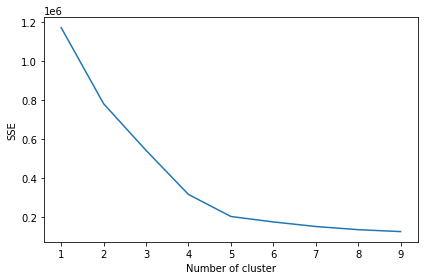

In [91]:
from sklearn.cluster import KMeans
#Clustering. Let's use the elbow method to get a sense of the optimal number of clusters. 
#i.e. sum of squared distances vs # of clusters
sse = []
for i in range(1, 10):
    sse.append(KMeans(n_clusters=i, init='k-means++', random_state=10).fit(data_cluster).inertia_)
  
plt.plot(range(1,10), sse)
plt.xlabel("Number of cluster")
plt.ylabel("SSE")

Looks like the optimal number of cluster is somewhere between 5 and 7. Let’s pick 7 and check the cluster characteristics.


In [92]:
clusters = KMeans(n_clusters=7, init='k-means++', random_state=10).fit(data_cluster)
  
#get cluster centroids
cluster_characteristics = pd.DataFrame(clusters.cluster_centers_, columns = data_cluster.columns)
  
#add cluster size and label
cluster_characteristics['size']=np.bincount(clusters.labels_)

In [94]:
cluster_characteristics['label']= range(0, clusters.n_clusters)

In [95]:
cluster_characteristics

,distance_from_home,time_delta_consecutive_transactions,distance_consecutive_transactions,transaction_dollar_amount,size,label
0,-0.109330,-0.478998,-0.156182,-0.125413,216792,0
1,-0.109613,2.497406,-0.152312,-0.121495,23797,1
2,10.619211,0.028317,7.489062,0.042237,1534,2
3,-0.089479,-0.002438,-0.102263,6.627694,5360,3
4,6.105349,-0.028084,4.271208,-0.076989,2521,4
5,-0.188376,-0.026344,5.639498,-0.095630,3870,5
6,-0.105291,1.130892,-0.152100,-0.124519,39727,6


It looks like some clusters are really extreme on at least one dimension. Let’s only pick the clusters with at least one dimension above 2 in absolute value. Since we scaled the data, this represents two standard deviations.


In [96]:
#These are going to be our anomaly clusters: at least one absolute value larger than 2.
anomaly_cluster = pd.melt(cluster_characteristics,id_vars=['label', 'size'],var_name='variable', value_name='value')
anomaly_cluster = anomaly_cluster.query('abs(value)>2').sort_values("label")
print(anomaly_cluster)

    label   size                             variable      value
8       1  23797  time_delta_consecutive_transactions   2.497406
2       2   1534                   distance_from_home  10.619211
16      2   1534    distance_consecutive_transactions   7.489062
24      3   5360            transaction_dollar_amount   6.627694
4       4   2521                   distance_from_home   6.105349
18      4   2521    distance_consecutive_transactions   4.271208
19      5   3870    distance_consecutive_transactions   5.639498


We can see that cluster 3 has transactions with huge values. Cluster 4 is weird because consecutive transactions are very far from each other. Cluster 2 and 5 are weird because they have both transactions that are far from the user home as well as consecutive transactions are also far from each other, with cluster 5 being even more extreme than cluster 2.

Finally, cluster 0 has transactions that happen after a long time. This is probably not a reason to flag a transaction as suspicious. So we won’t include it. We would have included it if time_delta_consecutive_transactions had been highly negative, meaning tons of transactions right after each other, which is pretty common when a CC gets stolen.


In [97]:
#get rid of cluster 0
anomaly_cluster = anomaly_cluster.query('variable!="time_delta_consecutive_transactions"')


In [98]:
#check proportion of anomaly events
print("Overall", round(anomaly_cluster['size'].unique().sum()/cluster_characteristics['size'].sum(), 3)*100,"percentage of events belong to anomaly clusters")

Overall 4.5 percentage of events belong to anomaly clusters


If we had chosen a more aggressive threshold than 2, we would have obviously got less anomalies and the other way round had we chosen a lower value. As usual, this would depend on the cost of false positives vs false negatives.

In [99]:
#Finally let's flag actual transactions
data_cluster['cluster'] = clusters.labels_
data_cluster['is_suspicious'] = data_cluster['cluster'].isin(anomaly_cluster['label'])


In [100]:
data_cluster.head()

,distance_from_home,time_delta_consecutive_transactions,distance_consecutive_transactions,transaction_dollar_amount,cluster,is_suspicious
38,-0.124064,-0.621641,-0.172901,-1.040795,0,False
46,-0.143078,-0.290164,-0.207107,0.064680,0,False
49,-0.106339,-0.450770,-0.153004,-0.035492,0,False
72,-0.111739,-0.528082,-0.155856,-0.228124,0,False
76,-0.118263,-0.622981,-0.170064,-0.112810,0,False


# Summary

A problem we have with the current model is that, in order for an event to be classified as an anomaly, we need k-means to create a specific cluster. That will typically happen only if we have several events with similar characteristics.

A possible way to solve that could be looking into the distance from their cluster centroid for the transactions belonging to non-anomaly clusters. If they are particularly far (meaning they are an outlier within a non-anomaly cluster), we could label them as an anomaly as well.

Another problem stems from the fact that we defined anomalies as “far from the typical behaviour of that specific user”. As always when you go on a user level, this will only work as long as you have enough events per user.

A common way to solve this is to create a hybrid approach. If, for a given user, we have > X transactions, we look for anomalies based on that user pattern. If we have <= X transactions, we define anomalies as events that are far from the typical behaviour of similar users (or of all users in the extreme case that you have no way to define similar users).
